# Exploratory Data Analysis in SQL and Python

Analyzing the San-Francisco Crime dataset Using SQL and Python for indepth analysis.<br>
We connect to MySQL server and workbench and make analysis with the crime_data database.

In [1]:
# we import some required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
import time
print('Done!')

Done!


In [3]:
import mysql
from mysql.connector import Error
from getpass import getpass

db_name = 'crime_data'
try:
    connection = mysql.connector.connect(host='localhost',
                                         database=db_name,
                                         user=input('Enter UserName:'),
                                         password=getpass('Enter Password:'))
    if connection.is_connected():
        db_Info = connection.get_server_info()
        print("Connected to MySQL Server version ", db_Info)
        cursor = connection.cursor()
        cursor.execute("select database();")
        record = cursor.fetchone()
        print("You're connected to database: ", record)

except Error as e:
    print("Error while connecting to MySQL", e)

Enter UserName:root
Enter Password:········
Connected to MySQL Server version  8.0.24
You're connected to database:  ('crime_data',)


In [4]:
def query_to_df(query):
    """This method converts the result
        of a SQL query to a DataFrame.
    @param query: Is a string of valid SQL syntax
    """
    
    st = time.time()
    # Assert Every Query ends with a semi-colon
    try:
        assert query.endswith(';')
    except AssertionError:
        return 'ERROR: Query Must End with ;'

    # so we never have more than 50 rows displayed
    pd.set_option('display.max_rows', 30) 
    df = None

    # Process the query
    cursor.execute(query)
    columns = cursor.description
    result = []
    for value in cursor.fetchall():
        tmp = {}
        for (index,column) in enumerate(value):
            tmp[columns[index][0]] = [column]
        result.append(tmp)

    # Create a DataFrame from all results
    for ind, data in enumerate(result):
        if ind >= 1:
            x = pd.DataFrame(data)
            df = pd.concat([df, x], ignore_index=True)
        else:
            df = pd.DataFrame(data)
    print(f'Query ran for {time.time()-st} secs!')
    return df

In [5]:
# Let's see the tables in crime_data database

query_to_df(
'SHOW TABLES;'
)

Query ran for 0.21067595481872559 secs!


,Tables_in_crime_data
0,sf_crime_data


In [6]:
# For the sf_crime_data

query = 'SELECT * FROM sf_crime_data LIMIT 3;'
query_to_df(query)

Query ran for 0.19225740432739258 secs!


,id,incidnt_num,category,descript,day_of_week,dates,times,pd_district,resolution,address,lon,lat,location
0,1,140000000,VEHICLE THEFT,STOLEN AND RECOVERED VEHICLE,Friday,01/31/2014 08:00:00 AM +0000,0 days 17:00:00,INGLESIDE,NONE,0 Block of GARRISON AV,-122.413628,37.709724,"(37.709725805163, -122.413623946206)"
1,2,140000000,ASSAULT,BATTERY,Friday,01/31/2014 08:00:00 AM +0000,0 days 17:45:00,TARAVAL,"ARREST, CITED",100 Block of FONT BL,-122.473709,37.715488,"(37.7154876086057, -122.47370623066)"
2,3,140000000,SUSPICIOUS OCC,SUSPICIOUS OCCURRENCE,Friday,01/31/2014 08:00:00 AM +0000,0 days 15:30:00,PARK,NONE,0 Block of CASTRO ST,-122.435722,37.768688,"(37.7686887134351, -122.435718550322)"


Let's see how many crimes have been reported

In [7]:
query_to_df(
"SELECT COUNT(*) total_crimes FROM sf_crime_data;"
)

Query ran for 0.20545315742492676 secs!


,total_crimes
0,30400


Let's see the different categories of offences

In [8]:
query_to_df(
"SELECT DISTINCT category FROM sf_crime_data;"
)

Query ran for 0.06740498542785645 secs!


,category
0,VEHICLE THEFT
1,ASSAULT
2,SUSPICIOUS OCC
3,OTHER OFFENSES
4,DRUG/NARCOTIC
...,...
31,BRIBERY
32,BAD CHECKS
33,RECOVERED VEHICLE
34,GAMBLING


Ok, there are 36 different categories of reported offences, let's see what types of crimes occur generally, from most to least frequent

In [9]:
query_to_df(
"SELECT DISTINCT category, COUNT(*) num_crimes FROM sf_crime_data GROUP BY 1 ORDER BY 2 DESC;"
)

Query ran for 0.10009884834289551 secs!


,category,num_crimes
0,LARCENY/THEFT,8211
1,OTHER OFFENSES,3719
2,NON-CRIMINAL,3554
3,ASSAULT,2399
4,VANDALISM,1545
...,...,...
31,"SEX OFFENSES, NON FORCIBLE",6
32,BAD CHECKS,4
33,GAMBLING,4
34,STOLEN PROPERTY,3


Let's zoom in on the Top 10 categories. 

Query ran for 0.05488419532775879 secs!


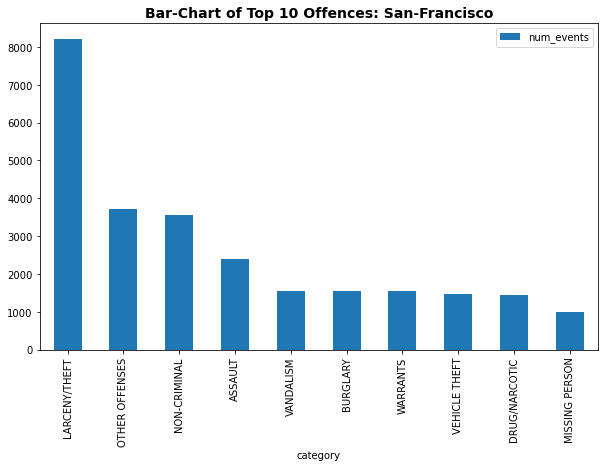

In [10]:
fdict = {'fontweight':'bold', 'fontsize':14}

(query_to_df(
"SELECT category, COUNT(*) num_events FROM sf_crime_data GROUP BY 1 ORDER BY 2 DESC LIMIT 10;"
)).set_index('category').plot.bar(figsize=(10,6))
plt.title('Bar-Chart of Top 10 Offences: San-Francisco', fontdict=fdict)
plt.show()

What percentage of total offences do the Top 10 offences constitute?

In [11]:
query_to_df(
"WITH \
t1 AS (SELECT DISTINCT category, COUNT(*) num_offences FROM sf_crime_data GROUP BY 1 ORDER BY 2 DESC LIMIT 10), \
t2 AS (SELECT SUM(num_offences) top_offences, (SUM(num_offences) / (SELECT COUNT(*) FROM sf_crime_data))*100 \
AS pct_top_offences FROM t1) \
SELECT * FROM t2;"
)

Query ran for 0.09885668754577637 secs!


,top_offences,pct_top_offences
0,26431,86.9441


So, the Top 10 categories of offences sum up to 26431 and contribute almost 87% of total offences reported.<br>Therefore for simplicity's sakes we shall focus on the distribution of these Top 10 offences.

We can see from the data that offences are recorded per district, in the variable `pd_district`. Let's see the unique districts from the data.

In [12]:
query_to_df(
"SELECT DISTINCT pd_district FROM sf_crime_data;"
)

Query ran for 0.030946969985961914 secs!


,pd_district
0,INGLESIDE
1,TARAVAL
2,PARK
3,CENTRAL
4,SOUTHERN
5,RICHMOND
6,BAYVIEW
7,MISSION
8,NORTHERN
9,TENDERLOIN


Now, let's write SQL query to extract the distribution of total Top-10-offences per district 

In [13]:
query_to_df(
"WITH \
t1 AS (SELECT DISTINCT category, COUNT(*) count FROM sf_crime_data GROUP BY 1 ORDER BY 2 DESC LIMIT 10), \
t2 AS (SELECT DISTINCT pd_district, COUNT(*) num_top_offences FROM sf_crime_data WHERE category IN \
(SELECT category FROM t1) GROUP BY 1 ORDER BY 2 DESC) \
SELECT * FROM t2;"
)

Query ran for 0.06887102127075195 secs!


,pd_district,num_top_offences
0,SOUTHERN,5218
1,MISSION,3448
2,NORTHERN,3389
3,CENTRAL,2789
4,BAYVIEW,2432
5,INGLESIDE,2205
6,TENDERLOIN,2185
7,TARAVAL,1747
8,PARK,1520
9,RICHMOND,1498


Let's visualize the distribution, using a horizontal barchart.

Query ran for 0.07851576805114746 secs!


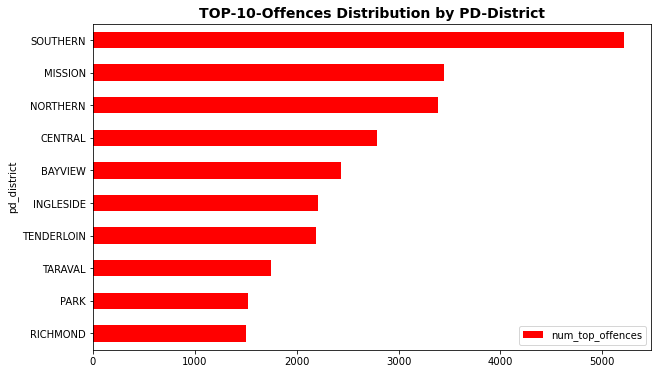

In [14]:
(query_to_df(
"WITH \
t1 AS (SELECT DISTINCT category, COUNT(*) count FROM sf_crime_data GROUP BY 1 ORDER BY 2 DESC LIMIT 10), \
t2 AS (SELECT DISTINCT pd_district, COUNT(*) num_top_offences FROM sf_crime_data WHERE category IN \
(SELECT category FROM t1) GROUP BY 1 ORDER BY 2) \
SELECT * FROM t2;"
)).set_index('pd_district').plot(kind='barh', figsize=(10,6), color='red')
plt.title('TOP-10-Offences Distribution by PD-District', fontdict=fdict)
plt.show()

Out of these 10 Districts, the Southern District has over twice the number of reported offences as 6 other districts: (`Bayview`, `Ingleside`, `Tenderloin`, `Taraval`, `Park`, `Richmond`).<br>`Southern`, `Mission` and `Northern` Districts are the Top 3 in terms of reported offences. While `Richmond` is lowest on reported offences.

From the `resolution` variable in the dataset, we can see that not all offences have been resolved in various Districts.<br>Let's investigate further District-wise. 

First, let's see the distribution of distinct explanation phrases used to describe resolution

In [15]:
query_to_df(
"SELECT DISTINCT resolution, COUNT(*) num_offences FROM sf_crime_data GROUP BY 1 ORDER BY 2 DESC;"
)

Query ran for 0.04587554931640625 secs!


,resolution,num_offences
0,NONE,18927
1,"ARREST, BOOKED",6505
2,"ARREST, CITED",2509
3,PSYCHOPATHIC CASE,1074
4,LOCATED,698
5,UNFOUNDED,170
6,JUVENILE BOOKED,147
7,COMPLAINANT REFUSES TO PROSECUTE,118
8,JUVENILE CITED,92
9,PROSECUTED BY OUTSIDE AGENCY,66


Some interesting findings here, almost `19000` out of `30400` cases are unresolved. That's about `62%` of cases. We also have `170` unfounded cases. These are offences that are simply not True or no evidence to support the reports. In some cases(`118`) the complainant refused to prosecute, that's interesting and the reasons are as varied as we can imagine. Then there are about `9000` arrested and booked or cited cases and about `280` cases involving Juveniles.

Let's see the split of top-offences, unresolved offences and offences inwhich arrests have been made per District.

In [76]:
# First query to select Distinct Districts and top offences

df1 = query_to_df(
"WITH \
t1 AS (SELECT DISTINCT category, COUNT(*) count FROM sf_crime_data GROUP BY 1 ORDER BY 2 DESC LIMIT 10), \
t2 AS (SELECT DISTINCT pd_district, COUNT(*) top_offences FROM sf_crime_data WHERE category IN \
(SELECT category FROM t1) GROUP BY 1 ORDER BY 2 DESC) \
SELECT * FROM t2;"
)

# Second query to select Distinct Districts and unresolved offences

df2 = query_to_df(
"SELECT DISTINCT pd_district, COUNT(*) unresolved FROM sf_crime_data WHERE resolution='NONE' GROUP BY 1;"
)

# Third query to select Distinct Districts and arrest_made offences

df3 = query_to_df(
"WITH \
t2 AS (SELECT DISTINCT pd_district, COUNT(*) arrest_made FROM sf_crime_data WHERE resolution LIKE '%ARREST%' GROUP BY 1 \
ORDER BY 2 DESC) \
SELECT * FROM t2;"
)

Query ran for 0.057417869567871094 secs!
Query ran for 0.03124380111694336 secs!
Query ran for 0.03127145767211914 secs!


Now we join the temporal tables from the three queries in the cell above using pandas DataFrame join into a combined DataFrame

In [77]:
df = df1.set_index('pd_district').join([df2.set_index('pd_district'), df3.set_index('pd_district')])

In [78]:
# Let's see the combined Dataframe

df

,top_offences,unresolved,arrest_made
pd_district,,,
SOUTHERN,5218,3587,1863
MISSION,3448,2275,1432
NORTHERN,3389,2775,790
CENTRAL,2789,2322,732
BAYVIEW,2432,1650,952
INGLESIDE,2205,1626,705
TENDERLOIN,2185,971,1400
TARAVAL,1747,1408,371
PARK,1520,1038,467


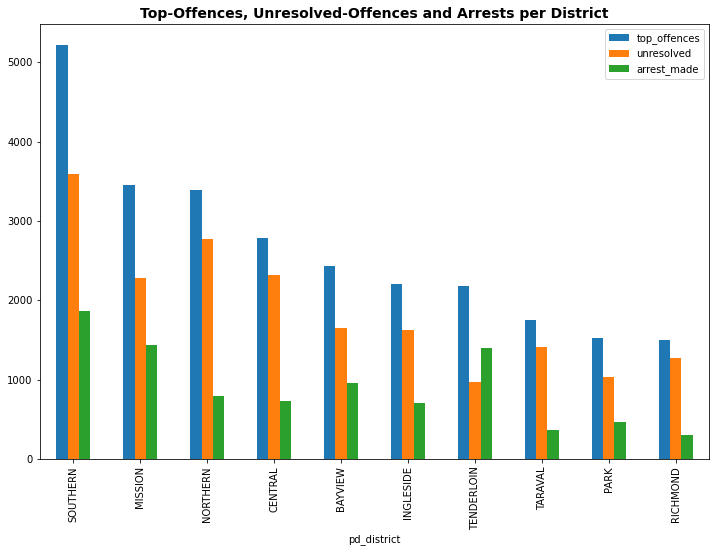

In [80]:
df.plot.bar(figsize=(12,8))
plt.title('Top-Offences, Unresolved-Offences and Arrests per District', fontdict=fdict)
plt.show()

We can see the split of unresolved cases to total top-cases in each district. Alarmingly, over half of all cases in each district go unresolved. We cannot directly answer why, but the data simply indicates a worrisome pattern of high unresolved cases per district.

Let's see the ratio of unresolved cases and cases where arrests have been made to the total number of offences per district.

In [81]:
df['pct_unresolved'] = (df['unresolved'] / df['top_offences']) * 100
df['pct_arrested'] = (df['arrest_made'] / df['top_offences']) * 100

In [82]:
# Let's see the updated Dataframe

df

,top_offences,unresolved,arrest_made,pct_unresolved,pct_arrested
pd_district,,,,,
SOUTHERN,5218,3587,1863,68.742813,35.703335
MISSION,3448,2275,1432,65.980278,41.531323
NORTHERN,3389,2775,790,81.882561,23.310711
CENTRAL,2789,2322,732,83.255647,26.245966
BAYVIEW,2432,1650,952,67.845395,39.144737
INGLESIDE,2205,1626,705,73.741497,31.972789
TENDERLOIN,2185,971,1400,44.439359,64.073227
TARAVAL,1747,1408,371,80.595306,21.236405
PARK,1520,1038,467,68.289474,30.723684


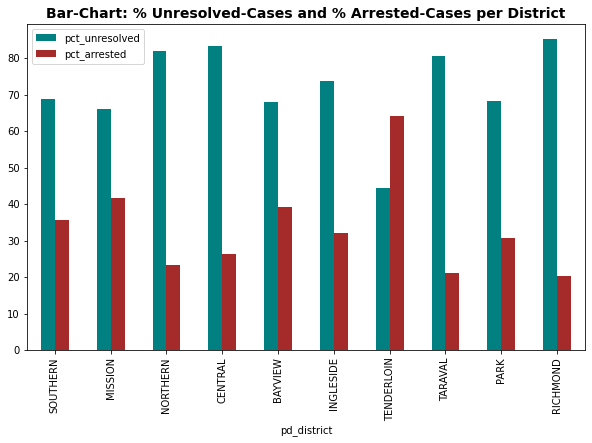

In [74]:
df1.loc[:, ['pct_unresolved', 'pct_arrested']].plot.bar(figsize=(10,6), color=['teal', 'brown'])
plt.title('Bar-Chart: % Unresolved-Cases and % Arrested-Cases per District', fontdict=fdict)
plt.show()

We have some really interesting insights here...

In [ ]:
# Change False to True below and run cell to terminate connection

if True and connection.is_connected():
    cursor.close()
    connection.close()
    print(f'Connection Terminated: {record} Database.')